This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.iris_data_utils as utils_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev import result_loading_utils

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

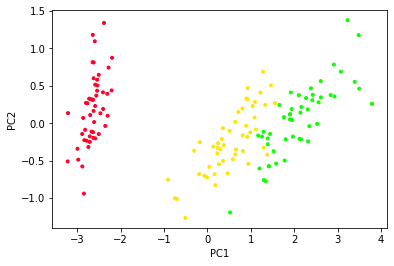

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 6.0
prior_params_dict['alpha'] = alpha0
print(prior_params_dict)

{'alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 15

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(iris_obs, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1593.68421456, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(iris_obs,
                                            vb_params_paragami, 
                                            n_kmeans_init = n_kmeans_init, 
                                            seed = 8901)

print('initial kl: ')
print(gmm_lib.get_kl(iris_obs, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
1652.98980495649


In [10]:
vb_params_dict = init_vb_params_dict

### Run CAVI

In [48]:
x_tol = 1e-3
vb_opt_dict, e_z_opt, _ = cavi_lib.run_cavi(iris_obs, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = True, 
                                            x_tol = x_tol)

Compiling CAVI update functions ... 
CAVI compile time: 2.78sec

Running CAVI ... 


AssertionError: e_z update failed

In [12]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [13]:
import inspect
lines = inspect.getsource(gmm_lib.get_kl)
print(lines)


def get_kl(y, vb_params_dict, prior_params_dict,
            gh_loc, gh_weights,
            e_z = None,
            use_bnp_prior = True):

    """
    Computes the negative ELBO using the data y, at the current variational
    parameters and at the current prior parameters

    Parameters
    ----------
    y : ndarray
        The array of datapoints, one observation per row.
    vb_params_dict : dictionary
        Dictionary of variational parameters.
    prior_params_dict : dictionary
        Dictionary of prior parameters.
    gh_loc : vector
        Locations for gauss-hermite quadrature. We need this compute the
        expected prior terms.
    gh_weights : vector
        Weights for gauss-hermite quadrature. We need this compute the
        expected prior terms.
    e_z : ndarray (optional)
        The optimal cluster belongings as a function of the variational
        parameters, stored in an array whose (n, k)th entry is the probability
        of the nth datapoint belonging

### Check results

In [14]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


### Plot centroids

Text(0, 0.5, 'PC2')

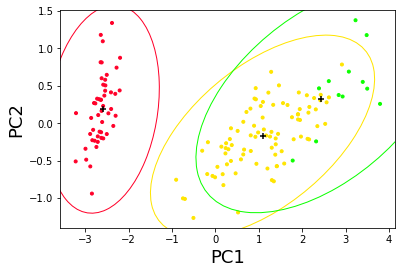

In [15]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [16]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [17]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

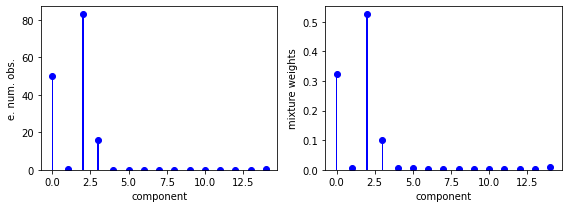

In [18]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Parametric sensitivity

### Compute derivatives

In [19]:
use_free_alpha = True
hyper_param0 = prior_params_paragami['alpha'].flatten(prior_params_dict['alpha'],
                                                      free = use_free_alpha)

In [20]:
hyper_param0

DeviceArray([1.79175947], dtype=float64)

In [21]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['alpha'] = alpha
    
    return gmm_lib.get_kl(iris_obs, vb_params_dict, _prior_params_dict,
                    gh_loc, gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

In [22]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 60.338sec

Compiling cross hessian...
Cross-hessian compile time: 0.995256sec

LR sensitivity time: 0.0743501sec



In [23]:
# double check the timing ... 

# cross hessian time
cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()
%timeit vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()

307 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
# solver time
%timeit vb_sens.hessian_solver(cross_hess.squeeze()).block_until_ready()

54.4 ms ± 50.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Fit for a range of alpha

In [25]:
alpha_list = np.arange(1, 15)

In [26]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_pert_dict = cavi_lib.run_cavi(iris_obs, deepcopy(new_init_dict),
                                     vb_params_paragami, prior_params_pert_dict,
                                     gh_loc, gh_weights,
                                     debug = False)[0]

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

In [27]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [28]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_list.append(refit_with_alpha(alpha, new_init_dict))


################
re-optimzing with alpha =  1
################
Compiling CAVI update functions ... 
CAVI compile time: 3.1sec

Running CAVI ... 
done. num iterations = 101
stick_time: 1.4sec
cluster_time: 1.1sec
e_z_time: 0.0414sec
**CAVI time: 2.68sec**

################
re-optimzing with alpha =  2
################
Compiling CAVI update functions ... 
CAVI compile time: 3.11sec

Running CAVI ... 
done. num iterations = 73
stick_time: 1.03sec
cluster_time: 0.0745sec
e_z_time: 0.0301sec
**CAVI time: 1.24sec**

################
re-optimzing with alpha =  3
################
Compiling CAVI update functions ... 
CAVI compile time: 2.76sec

Running CAVI ... 
done. num iterations = 58
stick_time: 0.798sec
cluster_time: 0.0589sec
e_z_time: 0.0242sec
**CAVI time: 0.961sec**

################
re-optimzing with alpha =  4
################
Compiling CAVI update functions ... 
CAVI compile time: 2.89sec

Running CAVI ... 
done. num iterations = 55
stick_time: 0.76sec
cluster_time: 0.0564sec
e_z_t

### Get linear response for each alpha

In [29]:
lr_list = []

for alpha in alpha_list: 
    
    hyper_param_pert = prior_params_paragami['alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert))

### Print results

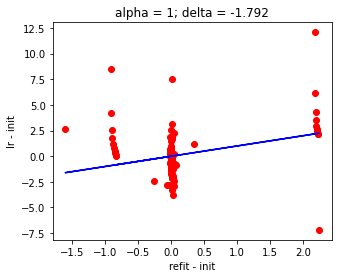

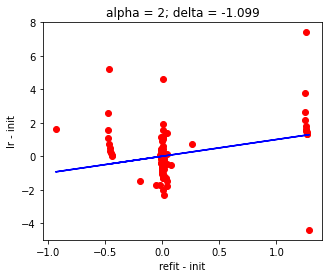

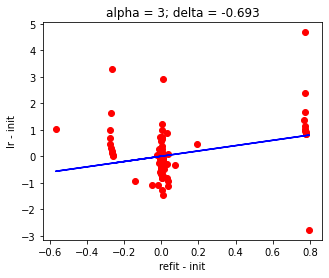

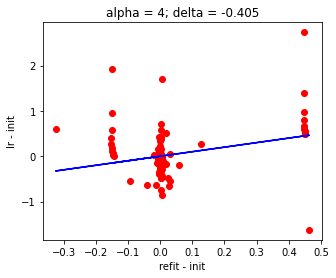

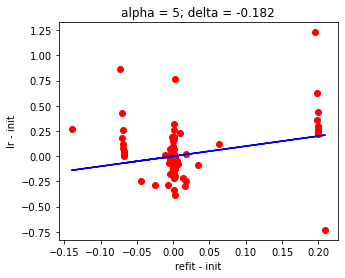

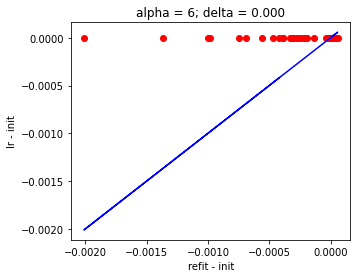

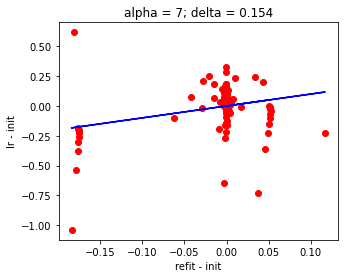

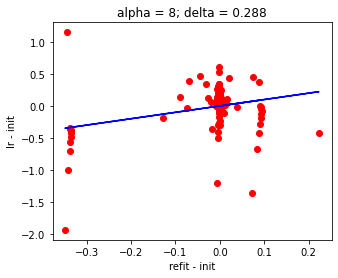

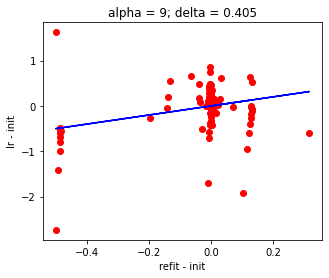

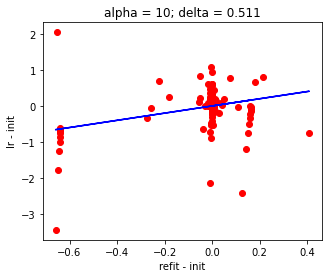

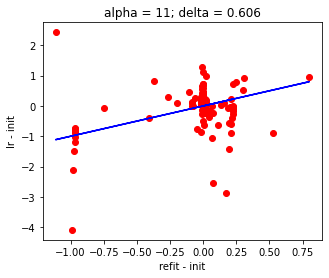

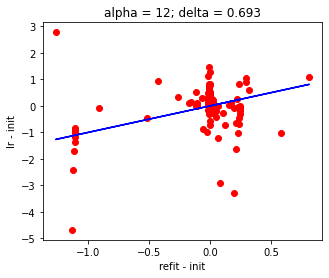

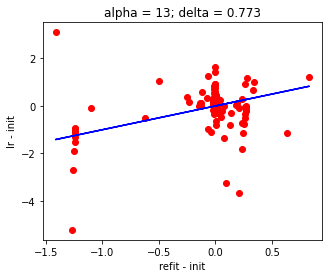

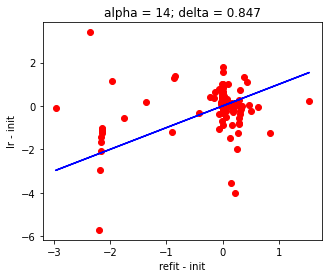

In [30]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                    lr_list[i],
                    vb_opt,
                    ax, alpha = 1.)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['alpha'].flatten(alpha,
                                                              free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [31]:
import numpy as onp

In [32]:
prng_key = jax.random.PRNGKey(223)
threshold = 0

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = threshold,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)

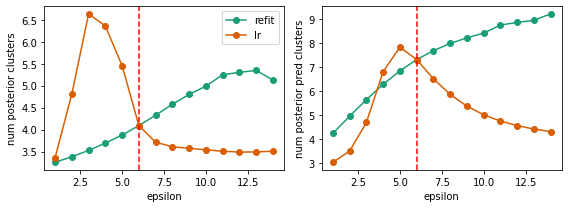

In [33]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend()

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')

fig.tight_layout()

# Some other posterior quantities

### Coclustering

In [34]:
import scipy.cluster.hierarchy as sch

In [35]:
# for better plotting, cluster the ez's
link = sch.linkage(e_z_opt, method='average')
indx = sch.dendrogram(link, no_plot=True)["leaves"]

In [36]:
@jax.jit
def get_coclustering(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    ez = gmm_lib.get_optimal_z_from_vb_dict(iris_obs,
                                            vb_params_dict,
                                            gh_loc,
                                            gh_weights,
                                            use_bnp_prior = True)[indx]
    
    return np.dot(ez, ez.transpose())

In [37]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()

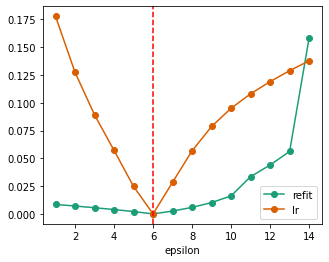

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_coclust_mean_abs_diff, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               ax)
ax.axvline(alpha0, 
           color = 'red', 
           linestyle = '--')

ax.legend()

In [39]:
# pick a particular alpha
alpha_pert = 8
alpha_indx = np.argwhere(alpha_list == alpha_pert).squeeze()

In [40]:
coclust_init = get_coclustering(vb_opt)
coclust_lr = get_coclustering(lr_list[alpha_indx])
coclust_refit = get_coclustering(refit_list[alpha_indx])

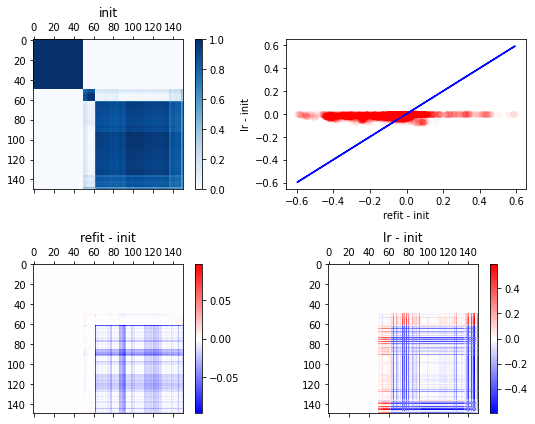

In [41]:
fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_lr.flatten(), 
                                    coclust_refit.flatten(),
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.01)

result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr[1], 
                                   plot_initial = False)
    
fig.tight_layout()

### Mixture weights

In [42]:
@jax.jit 
def get_mixture_weights(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    mixture_weights = gmm_lib.get_e_mixture_weights_from_vb_dict(vb_params_dict,
                                                                 gh_loc,
                                                                 gh_weights)
    
    return mixture_weights

In [43]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_mixture_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k))
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# obs)')
    
    fig.tight_layout()


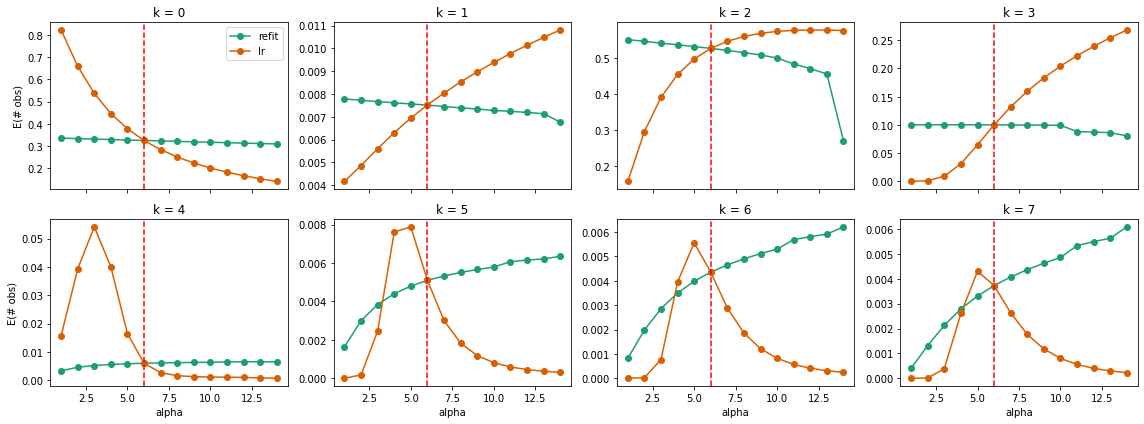

In [44]:
plot_e_num_obs_trace()

### Centroids

In [45]:
def get_centroids(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    centroids = vb_params_dict['cluster_params']['centroids']
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    return centroids_pc

In [46]:
centroids_init = get_centroids(vb_opt)

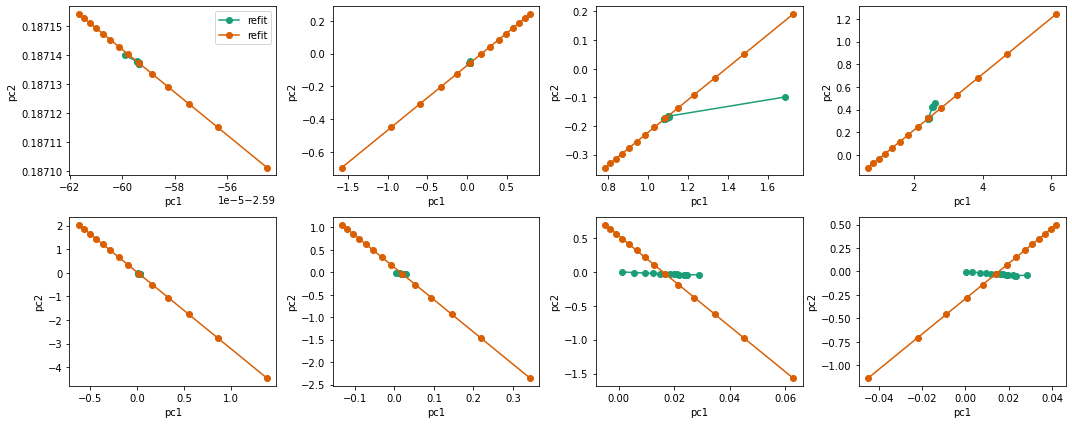

In [47]:
# get arrays of mixture weights
centroids_refit_array = result_loading_utils.get_post_stat_vec(get_centroids, refit_list)
centroids_lr_array = result_loading_utils.get_post_stat_vec(get_centroids, lr_list)
    
fig, axarr = plt.subplots(2, 4, figsize = (15, 6))
result_loading_utils.plot_centroids(centroids_refit_array, centroids_lr_array, axarr)
fig.tight_layout()
